# Quick Start

This session covers topics:

- a forecast task on iclaims dataset
- a simple Bayesian ETS Model using `CmdStanPy`
- posterior distribution extraction
- tools to visualize the forecast

## Load Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(orbit.__version__)

1.1.4.2


## Data

The *iclaims* data contains the weekly initial claims for US unemployment (obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA)) benefits against a few related Google trend queries (unemploy, filling and job) from Jan 2010 - June 2018. This aims to demo a similar dataset from the Bayesian Structural Time Series (BSTS) model [(Scott and Varian 2014)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf).

Note that the numbers are log-log transformed for fitting purpose and the discussion of **using the regressors** can be found in later chapters with the **Damped Local Trend (DLT)** model.

In [3]:
# load data
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
df.dtypes

/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/orbit/utils/dataset.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=["week"])


week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


Train-test split.

In [5]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## Forecasting Using Orbit

`Orbit` aims to provide an intuitive **initialize-fit-predict** interface for working with forecasting tasks. Under the hood, it utilizes probabilistic modeling API such as
`PyStan` and `Pyro`. We first illustrate a Bayesian implementation of Rob Hyndman's ETS (which stands for Error, Trend, and Seasonality) Model [(Hyndman et. al, 2008)](http://www.exponentialsmoothing.net/home) using `PyStan`.

In [18]:
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2024,
    estimator="stan-mcmc",
    stan_mcmc_args={'show_progress': False},
)

In [19]:
%%time
ets.fit(df=train_df)

2023-12-25 15:16:06 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CPU times: user 56.7 ms, sys: 23.4 ms, total: 80 ms
Wall time: 585 ms


In [20]:
predicted_df = ets.predict(df=test_df)

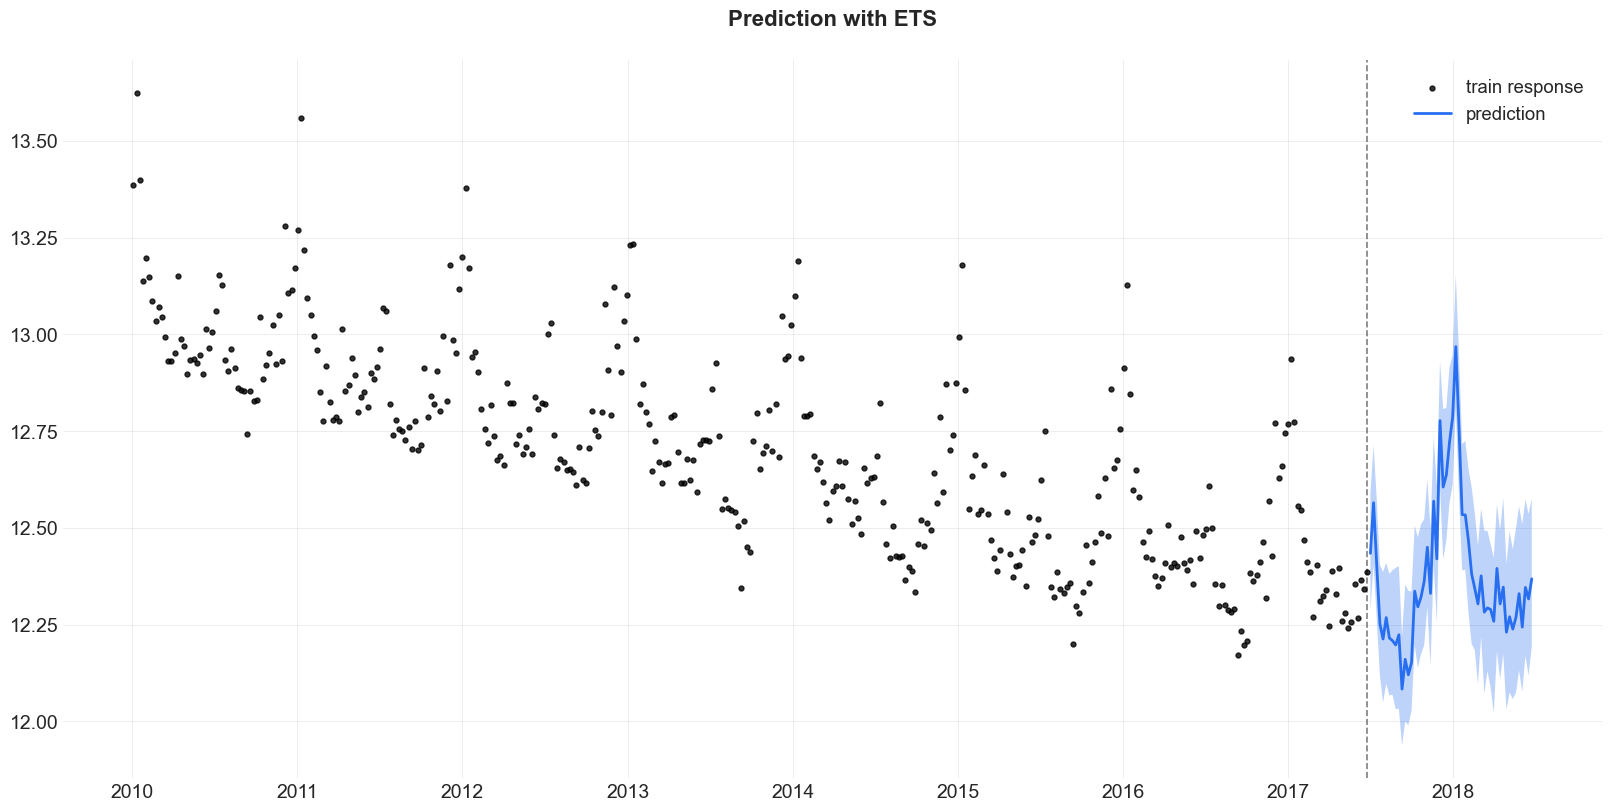

In [21]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETS')

## Extract and Analyze Posterior Samples

Users can use `.get_posterior_samples()` to extract posterior samples in an `OrderedDict` format.

In [10]:
posterior_samples = ets.get_posterior_samples()
posterior_samples.keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm', 'loglk'])

The extracted parameters posteriors are pretty much compatible diagnostic with [arviz](https://github.com/arviz-devs/arviz). To do that, users can set `permute=False` to preserve chain information.

/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


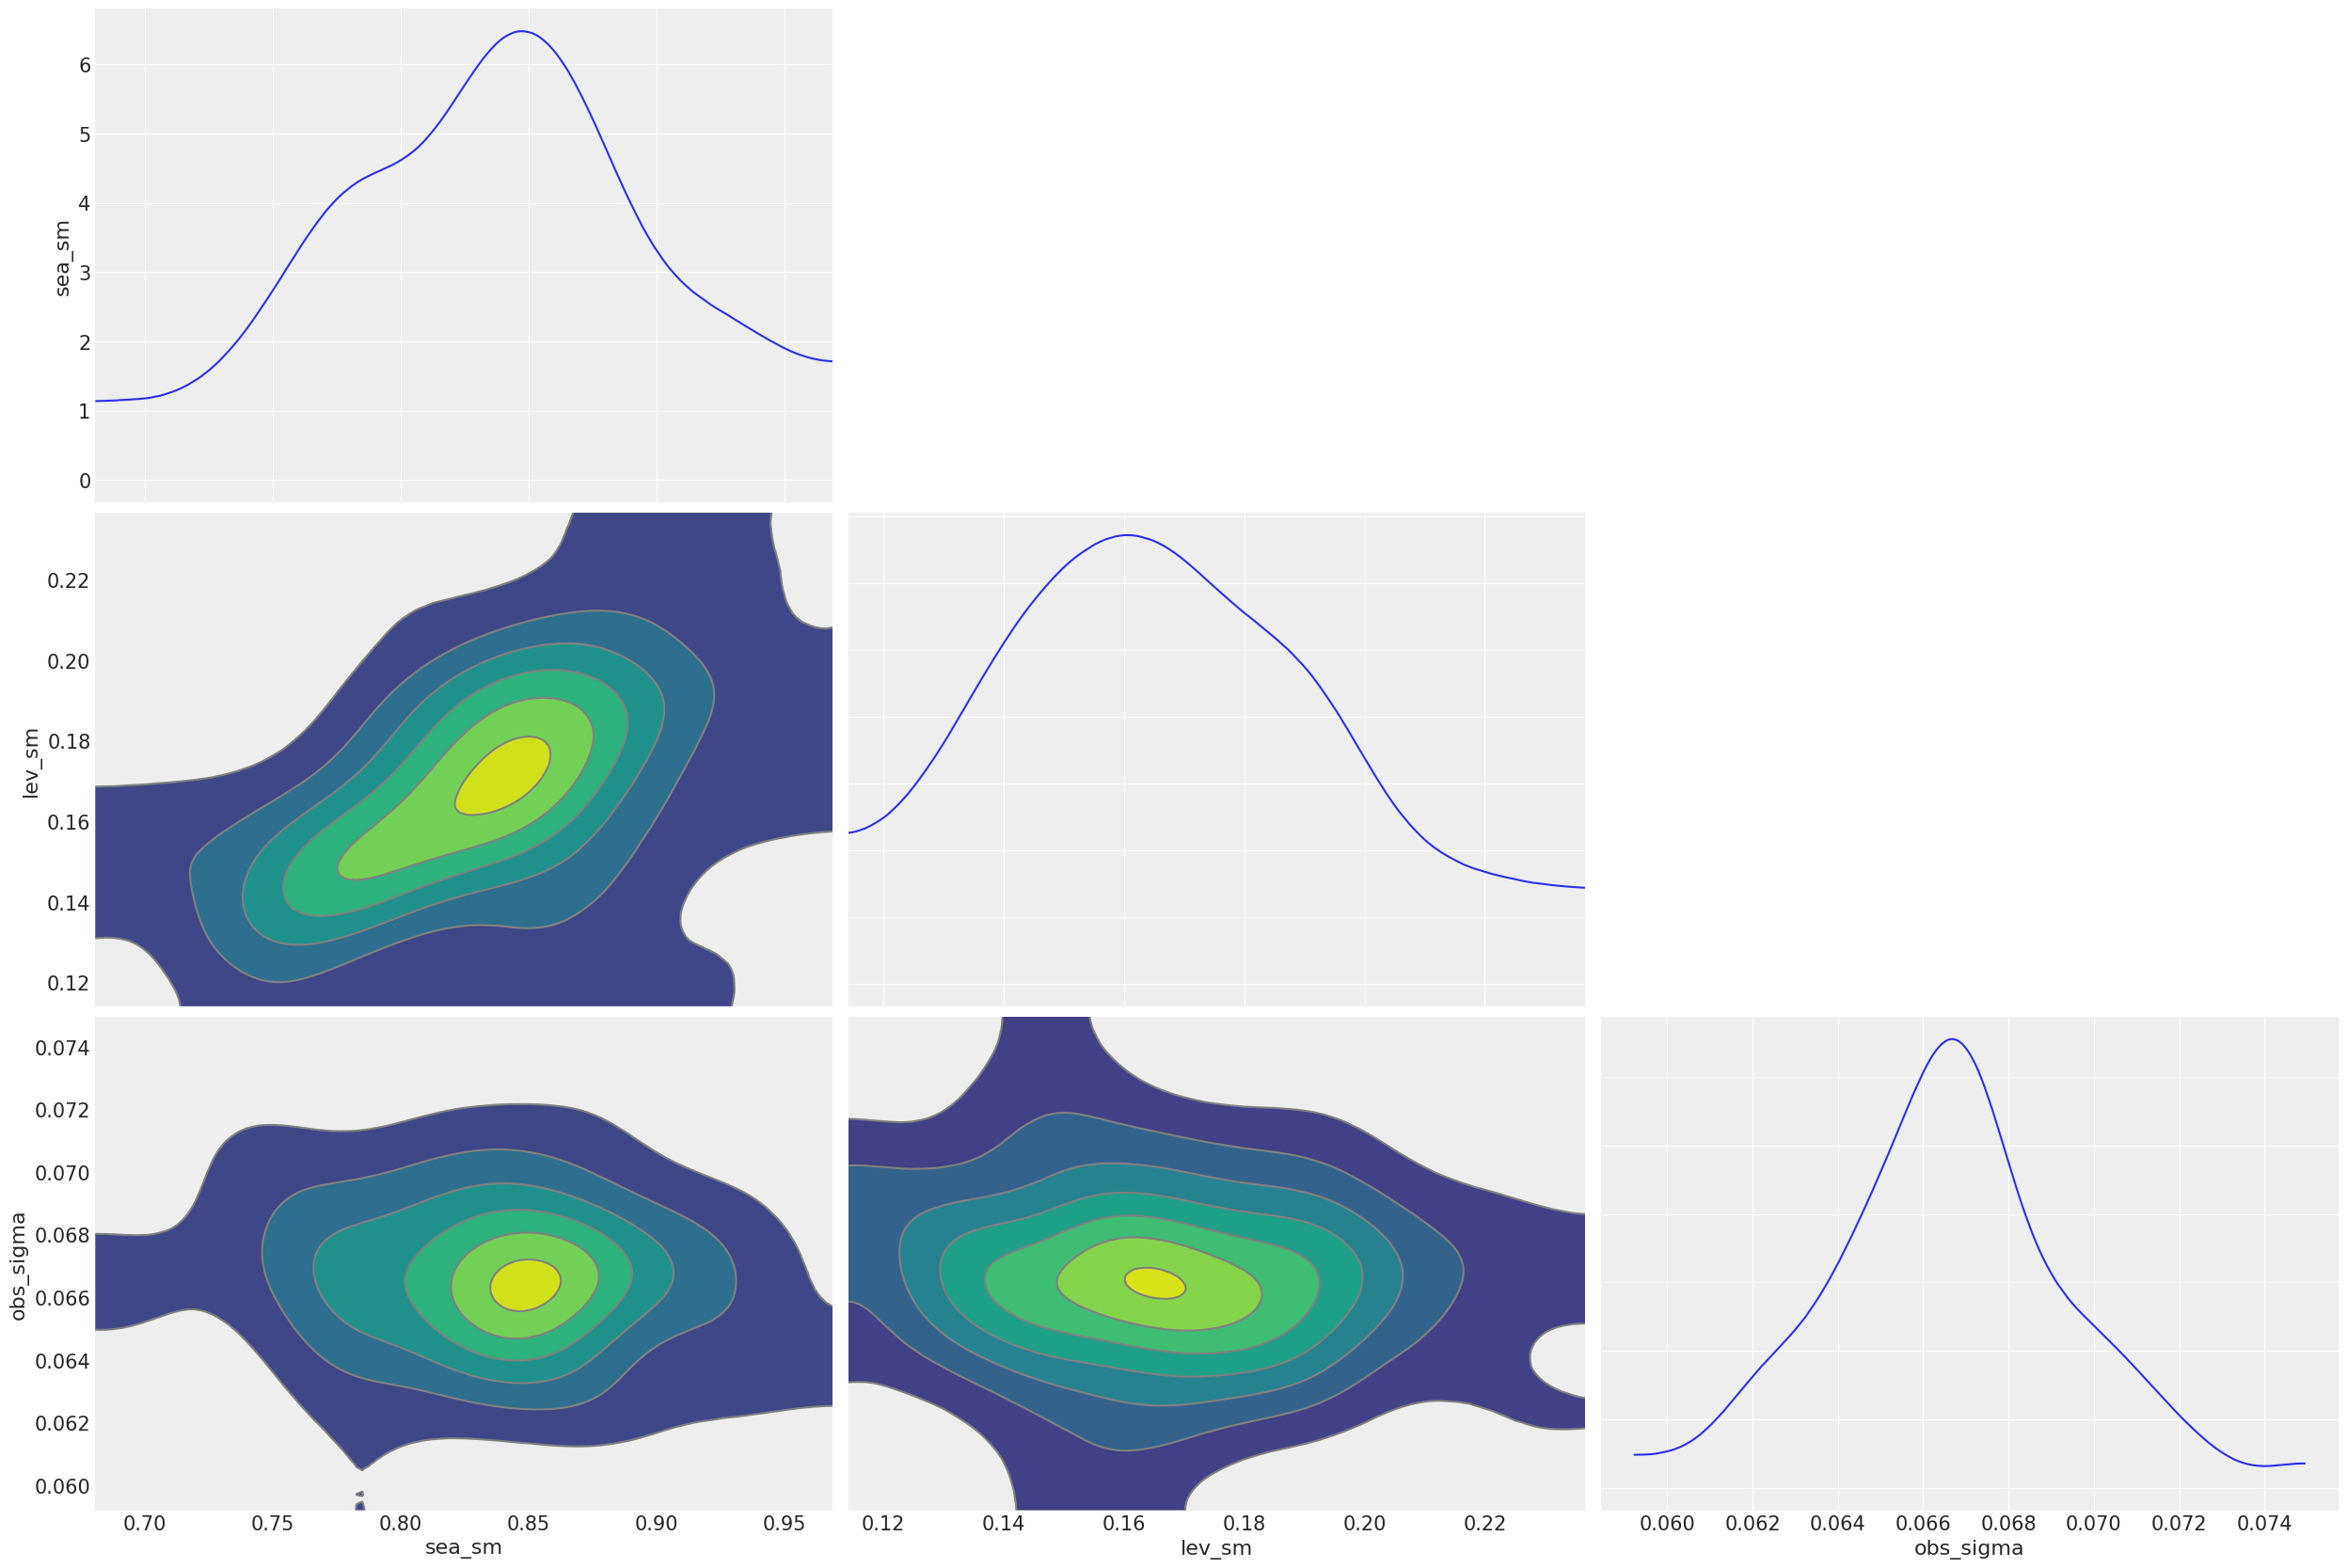

In [11]:
import arviz as az

posterior_samples = ets.get_posterior_samples(permute=False)

# example from https://arviz-devs.github.io/arviz/index.html
az.style.use("arviz-darkgrid")
az.plot_pair(
    posterior_samples,
    var_names=["sea_sm", "lev_sm", "obs_sigma"],
    kind="kde",
    marginals=True,
    textsize=15,
)
plt.show()

For more details in model diagnostics visualization, there is a subsequent section dedicated to it.